In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
len(df)

31072

### get better validation split since the classes are very unevenly represented

In [7]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

len(train_index), len(val_index), len(df)

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


(27958, 3114, 31072)

### set everything we need for creating a ImageMultiDataset

In [8]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
classes=[str(i) for i in range(28)]

In [9]:
trn_mask=[]

for i in range(len(df)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(31072, 27958, 3114)

### create train, valid and test ImageMultiDataset

In [10]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 27958, ImageMulti4Channel of len 3114)

In [11]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [12]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [13]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [14]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
#                      max_lighting=0.2, max_warp=0.2)

In [15]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.2, max_warp=0.)

In [16]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

### create ImageDataBunch from all this

In [17]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [18]:
bs = 48

In [19]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(protein_stats)

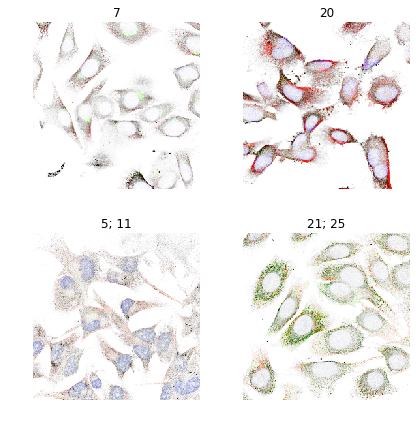

In [20]:
data.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

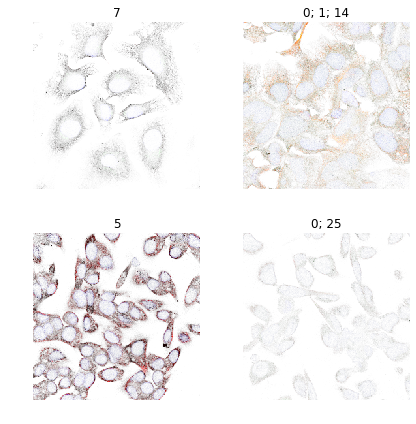

In [21]:
data.show_batch(rows=2, figsize=(6,6))

### create model and learner

In [22]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

def resnet101(pretrained=True):
    return Resnet4Channel(encoder_depth=101, pretrained=pretrained)

def resnet152(pretrained=True):
    return Resnet4Channel(encoder_depth=152, pretrained=pretrained)

In [23]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [24]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [25]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [26]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [27]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [28]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [29]:
#bce_logit_loss = partial(F.binary_cross_entropy_with_logits, pos_weight=weights)

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [31]:
learn = create_cnn(
    data,
    resnet50,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [32]:
learn.loss_func = FocalLoss()

In [33]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [34]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [36]:
learn.freeze()

In [37]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [38]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 27958),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [39]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


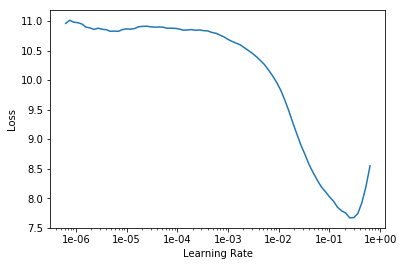

In [40]:
learn.recorder.plot()

In [41]:
lr = 1e-3

### fit the model (half image size)

Total time: 03:57
epoch  train_loss  valid_loss  fbeta  acc        
1      1.346799    1.118170    0.426344  0.951062  (03:56)



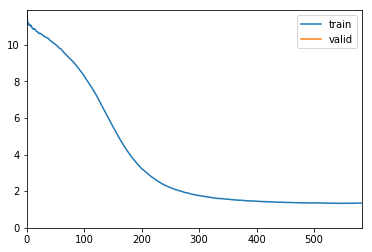

In [42]:
learn.fit_one_cycle(1, max_lr=slice(lr)) # sz 256

In [43]:
learn.save('halfsz_focal_res50_e1')

### unfreeze there resnet layers and train again 

In [39]:
learn.load('halfsz_focal_res50_e1')

In [44]:
learn.unfreeze()

In [45]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


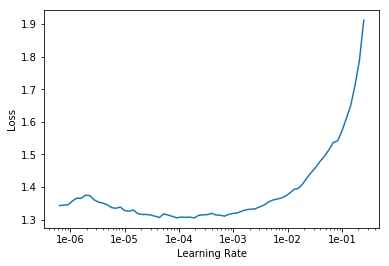

In [46]:
learn.recorder.plot() #resnet50

In [47]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [48]:
#lrs = slice(1e-5, 1e-4) 
lr = 2e-4
lrs = slice(lr/2, lr) 

In [49]:
learn.lr_range(lrs)

array([0.0001  , 0.000141, 0.0002  ])

Total time: 55:15
epoch  train_loss  valid_loss  fbeta  acc        
1      1.188692    0.990259    0.516664  0.955248  (04:46)
2      1.039045    0.867133    0.592170  0.959893  (04:49)
3      0.931122    0.815110    0.627229  0.961774  (04:43)
4      0.881036    0.776519    0.651953  0.963632  (04:38)
5      0.795122    0.718417    0.681563  0.965995  (04:39)
6      0.749750    0.700076    0.687446  0.966430  (04:40)
7      0.709859    0.649764    0.714873  0.969091  (04:39)
8      0.657702    0.629929    0.721199  0.970032  (04:31)
9      0.618173    0.606288    0.731231  0.970903  (04:26)
10     0.584400    0.589222    0.739113  0.971901  (04:25)
11     0.555062    0.581526    0.747530  0.972578  (04:25)
12     0.536915    0.580582    0.749640  0.972463  (04:25)



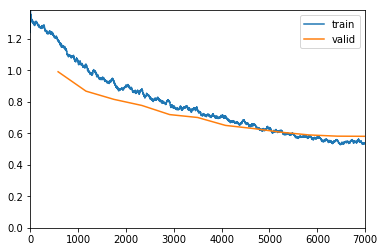

In [50]:
learn.fit_one_cycle(12, max_lr=lrs) # sz 256

In [51]:
learn.save('halfsz_focal_res50_e12')

### train on whole picture (512px)

In [35]:
bs = 14

In [36]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [37]:
learn = create_cnn(
    data,
    resnet50,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [38]:
learn.loss_func = FocalLoss()

In [39]:
learn.split(split_on=_resnet_split)

In [40]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [41]:
learn.load('halfsz_focal_res50_e12')

In [60]:
learn.freeze()

In [61]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


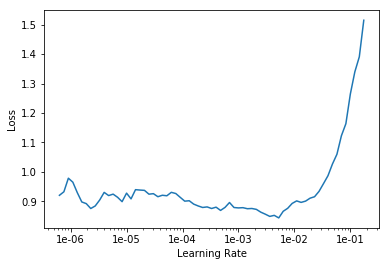

In [62]:
learn.recorder.plot()

In [44]:
lr = 1e-3

In [45]:
learn.fit_one_cycle(1, max_lr=slice(lr))

Total time: 29:02
epoch  train_loss  valid_loss  fbeta  acc        
1      0.753790    0.656950    0.733725  0.970481  (29:02)



In [46]:
learn.save('fullsz_focal_res101_e1')

In [37]:
#learn.load('fullsz_focal_res101_e1')
learn.load('halfsz_focal_res50_e12')

In [42]:
learn.unfreeze()

In [39]:
learn.lr_find(num_it=500)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


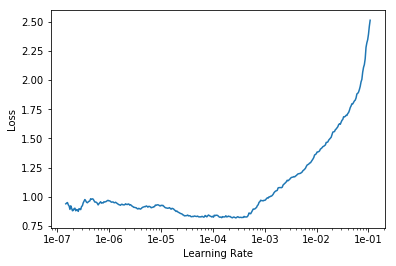

In [50]:
learn.recorder.plot() #resnet50 without frozen training

In [43]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [44]:
lr = 1e-4
#lr = 2e-4

lrs = slice(lr/2, lr)

In [45]:
learn.lr_range(lrs)

array([5.000000e-05, 7.071068e-05, 1.000000e-04])

epoch,train_loss,valid_loss,fbeta,acc
1,0.657372,0.592050,0.740293,0.972314
2,0.624826,0.575881,0.754669,0.973106
3,0.622052,0.572069,0.755767,0.972658
4,0.618493,0.572154,0.752234,0.973071
5,0.579122,0.560375,0.757940,0.973071
6,0.612872,0.566903,0.750102,0.973472
7,0.597871,0.573981,0.749787,0.972945
8,0.612532,0.576677,0.746058,0.972188
9,0.619894,0.584797,0.751713,0.972085
10,0.594745,0.600368,0.749918,0.972188


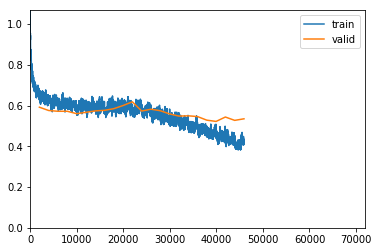

KeyboardInterrupt: 

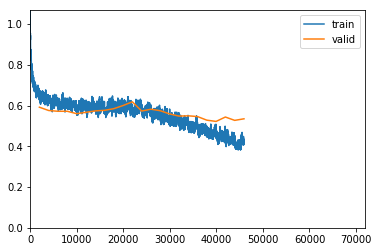

In [46]:
learn.fit_one_cycle(36, lrs) #2e-4 slice(lr/2, lr/1) resnet50, lr = 1e-4, lrs = slice(lr/2, lr) no BnFreeze

In [47]:
learn.load('bestmodel')

In [48]:
learn.save('fullsz_focal_res50_unfrozen_e36_BnFreeze')

Total time: 10:29:25
epoch  train_loss  valid_loss  fbeta  acc        
1      0.671338    0.599456    0.741709  0.971637  (18:49)
2      0.600572    0.566190    0.751621  0.973289  (18:52)
3      0.593822    0.557941    0.761742  0.973633  (18:37)
4      0.608219    0.564067    0.761212  0.973415  (17:36)
5      0.604712    0.565779    0.759877  0.973255  (17:33)
6      0.589631    0.588780    0.739407  0.972360  (17:32)
7      0.568764    0.575689    0.751334  0.972842  (17:21)
8      0.588598    0.571496    0.758410  0.973048  (17:20)
9      0.619794    0.599605    0.746428  0.972371  (17:20)
10     0.578639    0.580907    0.750184  0.972142  (17:19)
11     0.561883    0.578857    0.754384  0.973312  (17:20)
12     0.567634    0.576890    0.758397  0.973254  (17:20)
13     0.583269    0.600827    0.740529  0.971935  (17:20)
14     0.556572    0.578911    0.761321  0.973449  (17:20)
15     0.562809    0.567174    0.766900  0.973793  (17:20)
16     0.526519    0.556901    0.761244  0.9

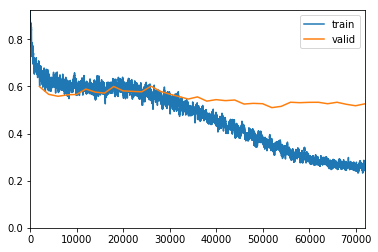

In [43]:
learn.fit_one_cycle(36, lrs) #2e-4 slice(lr/2, lr/1) resnet50, lr = 1e-4, lrs = slice(lr/2, lr)

### Try to find a good Threshold

In [50]:
learn.load('without_external/fullsz_focal_res50_unfrozen_e36_BnFreeze')

In [51]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [52]:
preds, y = learn.get_preds(DatasetType.Valid)

In [53]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:36



In [54]:
preds.shape, preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [55]:
act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [56]:
#np.set_printoptions(suppress=True)

In [57]:
act_preds[0].round(), y[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [58]:
act_preds.shape, act_preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [59]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

In [60]:
def getSingleThresh(preds, start, end, step):
    max_fbeta = 0
    max_th = 0
    for th in np.arange(start,end,step):
        if fbeta(preds, y, thresh=th, sigmoid=False) > max_fbeta:
            max_fbeta = fbeta(preds, y, thresh=th, sigmoid=False)
            max_th = th
    return max_fbeta, max_th

In [61]:
getSingleThresh(act_preds, 0, 1, 0.001)

(tensor(0.8230), 0.342)

In [62]:
getSingleThresh(act_preds_tta, 0, 1, 0.001)

(tensor(0.8229), 0.34600000000000003)

In [63]:
ensamble = act_preds * 0.1 + act_preds_tta * 0.9

In [64]:
getSingleThresh(ensamble, 0, 1, 0.001) 

(tensor(0.8236), 0.35000000000000003)

### predict test set 

In [66]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [67]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 20:11



In [68]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [69]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [70]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [72]:
ensamble_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9

In [91]:
tuned_weights = weights*0.85
tuned_weights

tensor([0.5100, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700,
        0.1700, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700, 0.3400, 0.3400,
        0.3400, 0.3400, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400,
        0.1700])

In [92]:
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.346)[0]])) \
#               for row in np.array(ensamble_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>(tuned_weights).numpy())[0]])) \
               for row in np.array(act_preds_t_tta)]

In [93]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [94]:
len(sub['Predicted'][sub['Predicted']==''])

54

In [95]:
test_matches = pd.read_csv(path/'test_matches.csv')

In [96]:
test_matches.head()

,Extra,Test,SimR,SimG,SimB,Target,Target_noisey
0,ENSG00000001497_44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,10,6,2,25 18 0,NaN
1,ENSG00000006194_35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,25 17 0,NaN
2,ENSG00000008324_47377_688_E7_10,b029f372-bad9-11e8-b2b9-ac1f6b6435d0,2,0,2,23 2,NaN
3,ENSG00000019186_63771_1414_D12_2,adc182fa-bad2-11e8-b2b8-ac1f6b6435d0,6,2,0,23 0 21,NaN
4,ENSG00000025770_67932_1255_A3_4,39508fe6-bad3-11e8-b2b8-ac1f6b6435d0,0,0,0,16 0,NaN


In [97]:
for _, row in test_matches.iterrows():
    print(sub[sub.Id == row.Test].Predicted)
    sub['Predicted'][sub.Id == row.Test] = row.Target
    print(sub[sub.Id == row.Test].Predicted)

5419    0 18 21 25
Name: Predicted, dtype: object
5419    25 18 0
Name: Predicted, dtype: object
3901    11 14
Name: Predicted, dtype: object
3901    25 17 0
Name: Predicted, dtype: object
8073    23 25
Name: Predicted, dtype: object
8073    23 2
Name: Predicted, dtype: object
7947    0 21 25
Name: Predicted, dtype: object
7947    23 0 21
Name: Predicted, dtype: object
2571    0 16
Name: Predicted, dtype: object
2571    16 0
Name: Predicted, dtype: object
7569    7 9 10 20
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
2214    0 14 25
Name: Predicted, dtype: object
2214    14 0
Name: Predicted, dtype: object
1838    14 25
Name: Predicted, dtype: object
1838    14
Name: Predicted, dtype: object
9721    14 16
Name: Predicted, dtype: object
9721    14
Name: Predicted, dtype: object
6119    0 16
Name: Predicted, dtype: object
6119    0
Name: Predicted, dtype: object
783    0 16 21
Name: Predicted, dtype: object
783    21
Name: Predicted, dtype: object
9781    7


8754    4 21
Name: Predicted, dtype: object
5466    0 2
Name: Predicted, dtype: object
5466    0
Name: Predicted, dtype: object
9881    0 12
Name: Predicted, dtype: object
9881    12
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
10215    4 17 25
Name: Predicted, dtype: object
10215    18 17
Name: Predicted, dtype: object
4345    23
Name: Predicted, dtype: object
4345    23
Name: Predicted, dtype: object
6479    0 16 25
Name: Predicted, dtype: object
6479    0
Name: Predicted, dtype: object
1108    1
Name: Predicted, dtype: object
1108    1 0
Name: Predicted, dtype: object
10394    0 13
Name: Predicted, dtype: object
10394    13
Name: Predicted, dtype: object
7993    0 13 21 25
Name: Predicted, dtype: object
7993    13
Name: Predicted, dtype: object
6806    12 14 21 25
Name: Predicted, dtype: object
6806    25 14
Name: Predicted, dtype: object
550    23
Name: Predicted, dtype: object
550    23
Name: Predicted, dtype: obj

Name: Predicted, dtype: object
9836    5
Name: Predicted, dtype: object
9836    5
Name: Predicted, dtype: object
5966    0 14 18 19 21 25
Name: Predicted, dtype: object
5966    25 18 14
Name: Predicted, dtype: object
488    4 23
Name: Predicted, dtype: object
488    23 4
Name: Predicted, dtype: object
9068    0 3 21 25
Name: Predicted, dtype: object
9068    25 0 21
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
6267    19
Name: Predicted, dtype: object
406    0 20 23
Name: Predicted, dtype: object
406    25 20
Name: Predicted, dtype: object
11535    0 20 23
Name: Predicted, dtype: object
11535    25 20
Name: Predicted, dtype: object
8265    0 4
Name: Predicted, dtype: object
8265    16 0
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
9047    0 2
Name: Predicted, dtype: object
9047    2 21
Name: Predicted, dtype: object
5299    7 25
Name: Predicted, dtype: object
5299    25 7
Name: Predicted, d

In [98]:
unique_target = df.groupby('Target')['Id'].nunique()

In [99]:
unique_target[unique_target>1000]

Target
0       2414
21      1058
23      1653
25      1470
25 0    1998
4       1077
7       1163
Name: Id, dtype: int64

In [100]:
sub['Predicted'][sub['Predicted']==''] = '0'

In [101]:
sub.to_csv(path/'resnet50.csv', header=True, index=False)

In [102]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '2 7 23 25',
 '4',
 '4 23 25',
 '0 23 25',
 '0',
 '4 21 25',
 '7 18 25',
 '3 5',
 '2 25',
 '7 20',
 '21 23 25',
 '2 7 18',
 '2 14',
 '5',
 '14 21',
 '5',
 '6 25',
 '2 8 25',
 '0 2 25',
 '0 21',
 '4 25',
 '12 20 21 23 25',
 '',
 '0',
 '0 25',
 '0 5',
 '13 21',
 '0 18',
 '14 17 18',
 '5',
 '0 7 25',
 '13',
 '25',
 '3',
 '21 23',
 '1',
 '0 25',
 '6 25',
 '0 21 25',
 '18 19 25',
 '25',
 '25 26',
 '0',
 '0 25',
 '6 23',
 '0',
 '16 17 25',
 '5',
 '20 23',
 '0 25',
 '3',
 '0 23 25',
 '0 25',
 '11 23 25',
 '0 25',
 '3 5 25',
 '2 20',
 '0 5 21',
 '14 25',
 '6 7 25',
 '23 25',
 '0 5 25',
 '3 21 25',
 '0',
 '0 20 25',
 '5 14',
 '2 8',
 '0 2 25',
 '14',
 '4',
 '21',
 '0',
 '4',
 '1 21 25',
 '0 25',
 '0 25',
 '0 5 25',
 '0 25',
 '25',
 '6 21 25',
 '18',
 '0 20 25',
 '7 23',
 '0 21',
 '20 25',
 '11 14 25',
 '25',
 '11',
 '23',
 '13',
 '23 25',
 '0 2 25',
 '7 19 21 25',
 '0 7 25',
 '2 24',
 '23 25',
 '11 25',
 '23',
 '11 23',
 '4 23',
 '6 7 25',
 '21 22 25',
 '14 1